<a href="https://colab.research.google.com/github/QuantumIIIV/SharpestMind/blob/master/03%20-%20Week%203%20-%206%20-%20Modeling/03_Microsoft_Spam_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### This is notebook is my first attempt to browse and visualize the data in the Microsoft Spam Database.

##### Data is from Microsoft Malware Prediction Competition in Kaggle https://www.kaggle.com/c/microsoft-malware-prediction
##### Some of code is borrowed from: https://www.kaggle.com/datark1/malware-prediction-eda

##### Let's load required libraries for ready data and visualizaion.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import os
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, make_scorer, roc_auc_score
from sklearn.utils   import shuffle

# print(os.listdir("C:/Users/Shahram/Desktop/Microsoft Spam/"))

##### The train.CSV file is almost 4GB. 
* Initially, I could not read the file as a whole so read the data in small chunks to figure out the columns and its content.
* After discussing with Debadyuti, he suggested to define the Types of columns and then use the Pandas read_csv to read all the data.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quantumiiiv","key":"4302a9fe6381c3191f76af2b3e6a0b6f"}'}

In [3]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 67 Nov  3 14:37 kaggle.json
{"username":"quantumiiiv","key":"4302a9fe6381c3191f76af2b3e6a0b6f"}

In [5]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 5.3MB 11.8MB/s 
     |████████████████████████████████| 112kB 38.8MB/s 
     |████████████████████████████████| 112kB 40.5MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


In [11]:
!kaggle competitions files microsoft-malware-prediction

name                    size  creationDate         
---------------------  -----  -------------------  
sample_submission.csv  277MB  2018-12-11 14:50:26  
test.csv                 4GB  2018-12-11 14:54:27  
train.csv                4GB  2018-12-11 14:52:57  


In [12]:
!kaggle competitions download -c microsoft-malware-prediction -p /content

 95% 127M/134M [00:01<00:00, 71.3MB/s]
100% 134M/134M [00:01<00:00, 73.3MB/s]
 98% 633M/643M [00:11<00:00, 59.2MB/s]
100% 643M/643M [00:11<00:00, 60.7MB/s]
 98% 721M/735M [00:11<00:00, 66.2MB/s]
100% 735M/735M [00:11<00:00, 67.2MB/s]


In [13]:
!unzip \train.csv.zip
!unzip \test.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

3 archives were successfully processed.


In [23]:
!rm \sample_submission.csv.zip
#!rm \sample_submission.csv
!rm \sample_data.csv
!rm \test.csv.zip
!rm \train.csv.zip


rm: cannot remove 'sample_submission.csv.zip': No such file or directory
rm: cannot remove 'test.csv.zip': No such file or directory
rm: cannot remove 'train.csv.zip': No such file or directory


In [24]:
!ls -l 

total 7988940
-rw-r--r-- 1 root root         67 Nov  3 14:37 kaggle.json
drwxr-xr-x 1 root root       4096 Oct 25 16:58 sample_data
---------- 1 root root 3795687226 Dec 11  2018 test.csv
---------- 1 root root 4384966482 Dec 11  2018 train.csv


In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', # was 'float32'
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', # was 'float16'
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }


train = pd.read_csv("train.csv", dtype=dtypes)
test  = pd.read_csv("test.csv", dtype=dtypes)

In [0]:
!rm \test.csv
!rm \train.csv

In [31]:
!ls

kaggle.json  sample_data


In [29]:
train.head()
#test.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0000010489e3af074adeac69c53e555e,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,58552.0,18.0,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2689.0,30661.0,4.0,5.0,...,488386.0,SSD,123179.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,807.0,8554.0,1,NaN,0.0,0,0,0.0,0.0,7.0
1,00000176ac758d54827acd545b6315a5,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,68,71395.0,NaN,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,...,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,554.0,33105.0,1,NaN,0.0,0,0,0.0,1.0,12.0
2,0000019dcefc128c2d4387c1273dae1d,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,NaN,49480.0,2.0,1.0,1,201,66202.0,NaN,267.0,251,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,NaN,NaN,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,...,29820.0,SSD,28678.0,0,4096.0,Notebook,13.9,1280.0,720.0,Mobile,NaN,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,556.0,63396.0,1,NaN,0.0,0,0,0.0,1.0,11.0
3,0000055553dc51b1295785415f1a224d,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,NaN,42160.0,2.0,1.0,1,29,120917.0,NaN,35.0,171,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,...,476940.0,HDD,439345.0,0,4096.0,Notebook,14.0,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.371,amd64,rs3_release,16299,371,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,26.0,119,Notify,0,IS_GENUINE,OEM:D

#### Let's see the data and its columns:
* There are almost 8.921 Million records with 83 columns. Memory usage is around 1.9 GB. the columns type is as we defined.

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float32
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                         

In [0]:
train.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,8.921483e+06,8889165.0,8.921483e+06,433438.000000,8.885262e+06,8885262.0,8885262.0,8.921483e+06,8.921483e+06,8.596074e+06,...,8.761350e+06,8.921483e+06,3.261780e+06,8.905530e+06,8.921483e+06,8.921483e+06,8850140.0,8618032.0,8618032.0,8.921483e+06
mean,7.509962e-06,NaN,1.733378e-02,1658.903809,4.948320e+04,NaN,NaN,9.879711e-01,1.080490e+02,8.049152e+04,...,3.268055e+04,4.860229e-01,2.980232e-07,7.202148e-03,1.255431e-01,3.807091e-02,NaN,NaN,NaN,4.997927e-01
std,2.740421e-03,0.0,1.305118e-01,999.028870,1.379994e+04,0.0,0.0,1.090149e-01,6.304706e+01,4.873461e+04,...,2.112612e+04,4.998046e-01,5.459785e-04,8.453369e-02,3.313338e-01,1.913675e-01,0.0,0.0,0.0,5.000000e-01
min,0.000000e+00,0.0,0.000000e+00,1.000000,3.000000e+00,0.0,0.0,0.000000e+00,1.000000e+00,5.000000e+00,...,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.000000e+00
25%,0.000000e+00,7.0,0.000000e+00,788.000000,4.948000e+04,1.0,1.0,1.000000e+00,5.100000e+01,3.682500e+04,...,1.315600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,3.0,0.000000e+00
50%,0.000000e+00,7.0,0.000000e+00,1632.000000,5.344700e+04,1.0,1.0,1.000000e+00,9.700000e+01,8.237300e+04,...,3.307000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,10.0,0.000000e+00
75%,0.000000e+00,7.0,0.000000e+00,2373.000000,5.344700e+04,2.0,1.0,1.000000e+00,1.620000e+02,1.237000e+05,...,5.243600e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,11.0,1.000000e+00
max,1.000000e+00,35.0,1.000000e+00,3213.000000,7.050700e+04,7.0,5.0,1.000000e+00,2.220000e+02,1.679620e+05,...,7.210500e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0,15.0,1.000000e+00


#### We will explore the number of unique products and the Engione version in this data sets.

In [32]:
print ("There are", len (train.ProductName.unique().tolist()), "distinct products.", train.ProductName.unique().tolist())
print ("There are", len (train.EngineVersion.unique()), "distinct version of these products.")

There are 6 distinct products. ['win8defender', 'mse', 'mseprerelease', 'windowsintune', 'fep', 'scep']
There are 70 distinct version of these products.


### Let's look at distribution of the Devices where a malware has been detected.
#### It is clear that the there is equal distribution of devices with malware detected and device without any malware.

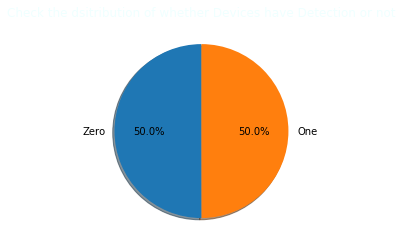

In [0]:
Zero = (train['HasDetections']==0).sum()
One  = (train['HasDetections']==1).sum()
sizes = [Zero,One]
labels = ['Zero','One']
fig1, ax1 = plt.subplots()
plt.title("Check the dsitribution of whether Devices have Detection or not", fontdict=None, loc='center', pad=None, color = "azure")
ax1.pie(sizes, labels = labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.show()

#### Let's see which columns are binary: 
###### I wrote the code myself but got help from https://www.kaggle.com/datark1/malware-prediction-eda

In [0]:
def FindBinaryColumns (data):
    BinaryColumns = []
    for column in data.select_dtypes (include = ['int8', 'int16', 'int32', 'int16', 'float32', 'float64']):
        if ( data [column].min()) == 0 or (data[column].max() == 1):
            BinaryColumns.append (column)
    return BinaryColumns

In [0]:
BinaryColumns = FindBinaryColumns(train)

In [35]:
print ('There are', len(FindBinaryColumns(train)),'columns which are Binary.')

There are 15 columns which are Binary.


#### Let's visually look at the percentage of zeros and ones in Digital columns.

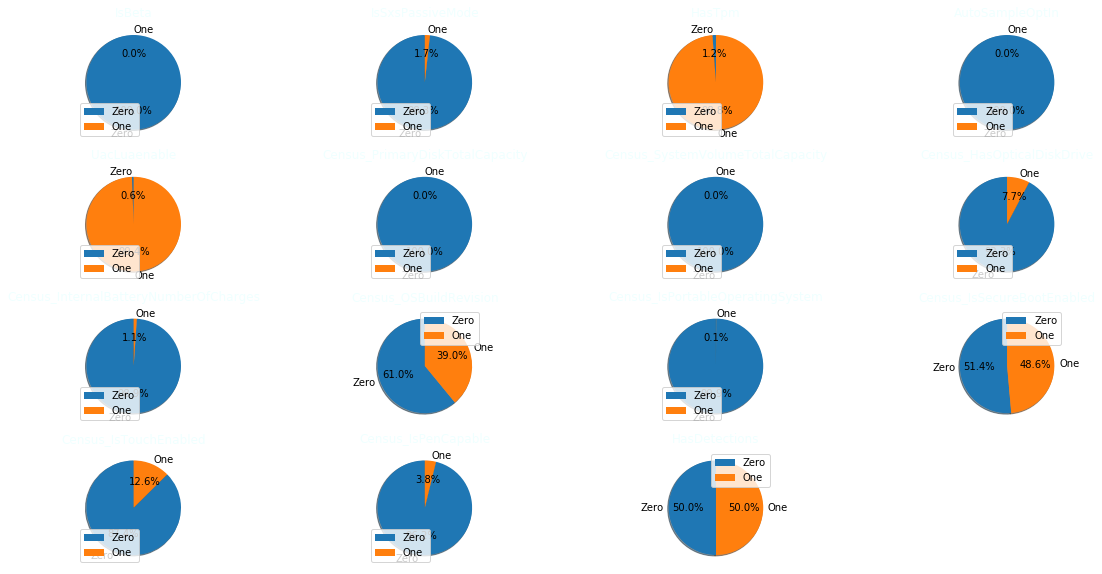

In [36]:
fig = plt.figure(figsize=(20,10))
for i, num in zip(BinaryColumns, range(1,20)):
    Zero = (train[i]==0).sum()
    One = (train[i]==1).sum()
    sizes = [Zero,One]
    labels = ['Zero','One']
    ax = fig.add_subplot(4,4,num) #fig1, ax1 = plt.subplots()
    plt.title(i, fontdict=None, loc='center', pad=None, color = "azure")
    ax.pie(sizes, labels = labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax.legend()

plt.show()

#### We should take a look to see if the columns are correlated.
##### As one can see aside from few columns ( which are in the vicinity of each other, the rest of the data are NOT Correlated.
##### Few columns are negatively correlated. (e.g.: RtpStateBitField - IsSXSPassiveMode)


#### Reference: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

corr = train.corr()
plt.figure(figsize=(22,12))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#### Counting the number of Null values in columns and calculating the percentages
#### We can use this conclusion to find out which columns we can drop from our calculations.
#### As one can see, there are 7 columns with more than 50% row of null values.

In [0]:
def GenMissingValueTable (data):
    NoEmptyRows = []
    percentages = []
    ColumnType = []

    for col in train:
        ColumnType.append(data[col].dtype)
        NoEmptyRows.append(data[col].isnull().sum())
        percentages.append((data[col].isnull().sum()/train.shape[0])*100)
    
    MissingValueTable = pd.DataFrame ({'Column Name': data.columns, 'Data Type': ColumnType, 
                                   'Number of Empty Rows': NoEmptyRows,'Percentages':percentages})
    
    return MissingValueTable

In [0]:
MissingValueTable =  GenMissingValueTable (train)

In [39]:
MissingValueTable

,Column Name,Data Type,Number of Empty Rows,Percentages
0,MachineIdentifier,category,0,0.000000
1,ProductName,category,0,0.000000
2,EngineVersion,category,0,0.000000
3,AppVersion,category,0,0.000000
4,AvSigVersion,category,0,0.000000
...,...,...,...,...
78,Census_IsPenCapable,int8,0,0.000000
79,Census_IsAlwaysOnAlwaysConnectedCapable,float16,71343,0.799676
80,Wdft_IsGamer,float16,303451,3.401352
81,Wdft_RegionIdentifier,float16,303451,3.401352


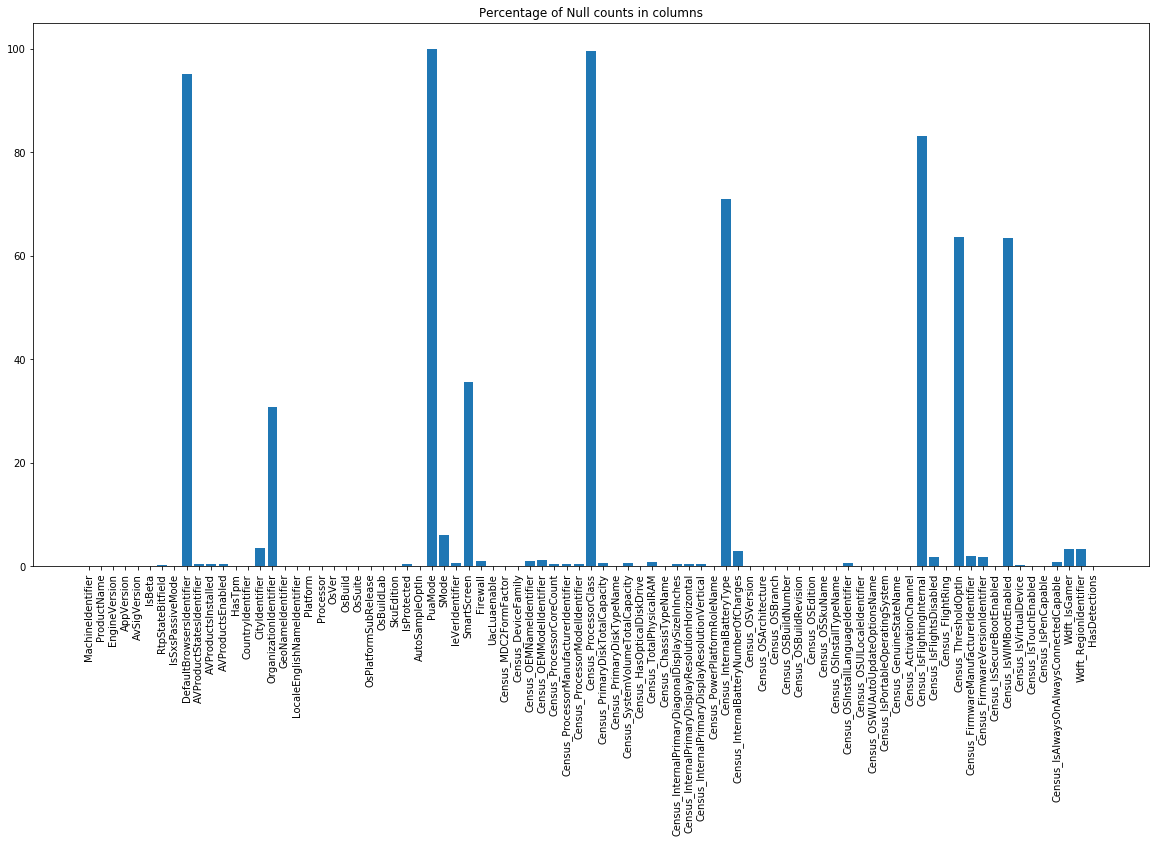

In [40]:
# Graph Missing Value Percentages
plt.figure(figsize=(20,10))
plt.title("Percentage of Null counts in columns", fontdict=None, loc='center', pad=None)
plt.xticks(rotation='vertical')
plt.bar(x = MissingValueTable['Column Name'], height = MissingValueTable['Percentages'])
plt.show()

### Let's group infected machines by the "platform".
#### Windows 10 is the major infected platform with more than 4 million machines infected.

In [0]:
group = ['Platform', 'HasDetections']
test = train.groupby(group).size().sort_index()

In [0]:
Test = pd.DataFrame (test)

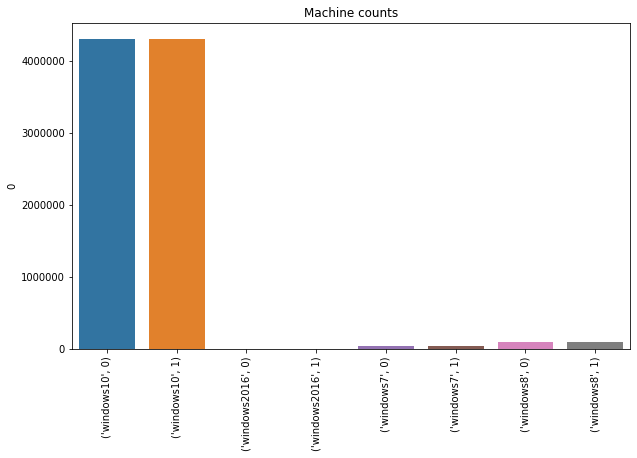

In [43]:
# Graph Missing Value Percentages
plt.figure(figsize=(10,6))
plt.title("Machine counts", fontdict=None, loc='center', pad=None)
plt.xticks(rotation='vertical')
plt.ylabel("Number of machines") #ax.set_ylabel('Probability density')
sns.barplot(x = test.index, y = Test[0])
plt.show()

### Let's group infected machines by Form Factor.

#### It is clear that Notebooks are majorly hit by malwares and then desktops and convertibles stand second and third respectively.

In [0]:
group = ['Census_MDC2FormFactor', 'HasDetections']
test = train.groupby(group).size().sort_index()

In [0]:
Test = pd.DataFrame (test)

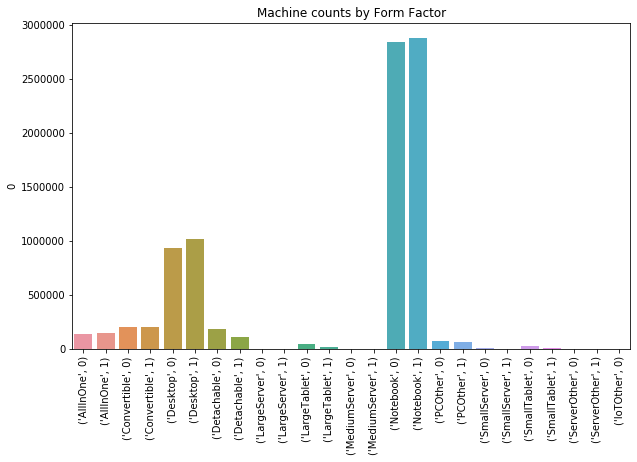

In [46]:
# Graph Missing Value Percentages
plt.figure(figsize=(10,6))
plt.title("Machine counts by Form Factor", fontdict=None, loc='center', pad=None)
plt.xticks(rotation='vertical')
plt.ylabel("Number of machines") 
sns.barplot(x = test.index, y = Test[0])
plt.show()

### Let's group infected machines by whether they are a Gamer or not.
#### It is clear that the gamer machine (wehether infected or not) are more than half of the non-gamers. Clearly, among the gamer machine infection is more (probable).

In [0]:
group = ['Wdft_IsGamer', 'HasDetections']
test = train.groupby(group).size().sort_index()

In [0]:
Test = pd.DataFrame (test)

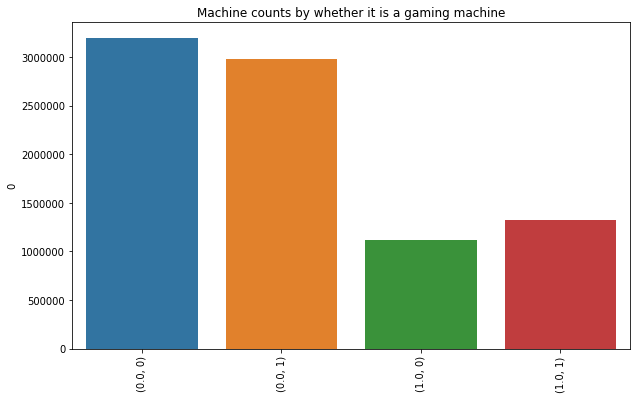

In [49]:
# Graph Missing Value Percentages
plt.figure(figsize=(10,6))
plt.title("Machine counts by whether it is a gaming machine", fontdict=None, loc='center', pad=None)
plt.xticks(rotation='vertical')
plt.ylabel("Number of machines") 
sns.barplot(x = test.index, y = Test[0])
plt.show()

In [50]:
BinaryColumns

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'UacLuaenable',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildRevision',
 'Census_IsPortableOperatingSystem',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'HasDetections']

In [51]:
CategoryColumns = train.select_dtypes (include = ['category']).columns
# CategoryColumns
BinaryColumns.extend(CategoryColumns)
CategoryColumns
# BinaryColumns

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'Platform', 'Processor', 'OsVer',
       'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode',
       'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_ProcessorClass', 'Census_PrimaryDiskTypeName',
       'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
       'Census_InternalBatteryType', 'Census_OSVersion',
       'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition',
       'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_FlightRing'],
      dtype='object')

In [0]:
ColumnsExcluded = train.columns.difference(BinaryColumns)

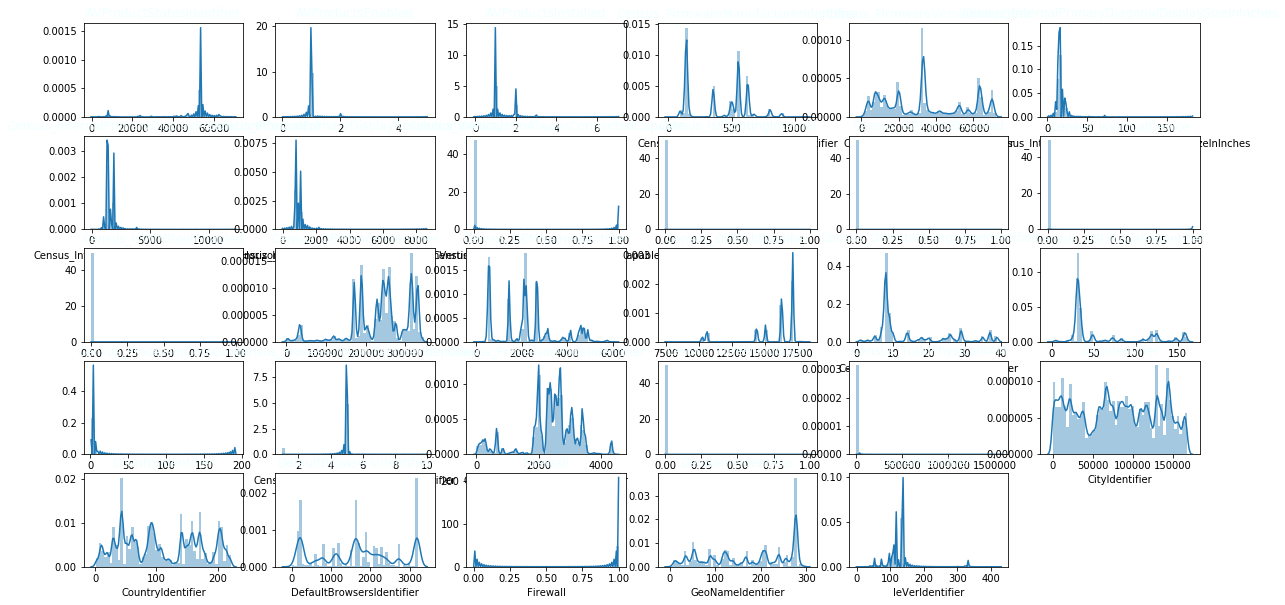

In [53]:
fig = plt.figure(figsize=(20,10))
for i, num in zip(ColumnsExcluded, range(1,30)):
    
    ax = fig.add_subplot(5,6,num) #fig1, ax1 = plt.subplots()
    plt.title(i, fontdict=None, loc='center', pad=None, color = "azure")
    sns.distplot(train[i].dropna())
    #ax.legend()

plt.show()

### Summary:
* We used the data in Microsoft Malware database.
* The data contain around 8.92 million record and 83 column. Fifteen columns are binary. We made a pie chart to see the distributoion of the Binary columns.
* The Target column which is HasDetectiosn is equally distributed.
* We graphed the heatmap of correlation of columns and saw that few columns are correlted. (Two columns are strongly negatively correlated and a few are positivley correlated.)
* we also grahphed the malware infected devices by platform and Form Factor and Windows versio.
* Windos 10 and laptops are the most infected machines.
* We also graphed the histogram of the rmeainning columns to see the distribution of the data.
* Few columns (around 7) have more than 50% of their data mssining (Null value) and hence might be a good idea to ignore them in the data engineering. We ideate that the other columns with less missing values can be filled with mean or median of the column.


### The rest of this note book is related to Feature Engineering.

#### I am going to drop the columns with more than 10% missing vlaues which are around 9 or 10 columns.

In [54]:
print ("There are ", (MissingValueTable['Percentages']>=10).sum(), "columns with more than 10 % of rows with missing values.")
MissingValueTable [(MissingValueTable['Percentages']>=10)]

There are  9 columns with more than 10 % of rows with missing values.


,Column Name,Data Type,Number of Empty Rows,Percentages
8,DefaultBrowsersIdentifier,float32,8488045,95.141637
15,OrganizationIdentifier,float16,2751518,30.841487
28,PuaMode,category,8919174,99.974119
31,SmartScreen,category,3177011,35.610795
41,Census_ProcessorClass,category,8884852,99.589407
52,Census_InternalBatteryType,category,6338429,71.046809
68,Census_IsFlightingInternal,float16,7408759,83.044030
71,Census_ThresholdOptIn,float16,5667325,63.524472
75,Census_IsWIMBootEnabled,float16,5659703,63.439038


In [0]:
train = train.drop(MissingValueTable [(MissingValueTable['Percentages']>=10)]['Column Name'], axis = 1)

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 74 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                                       float32
GeoNameIdentifier                      

#### There are 35 columns with between 0 to 10 % rows missing.

In [57]:
MissingValueTable [(MissingValueTable['Percentages']<=10) & (MissingValueTable['Percentages']>0)].count()

Column Name             35
Data Type               35
Number of Empty Rows    35
Percentages             35
dtype: int64

In [0]:
# MissingValueTable [(MissingValueTable['Percentages']<=10) & (MissingValueTable['Percentages']>0)]

In [0]:
ColumnsWMissingValue = MissingValueTable [(MissingValueTable['Percentages']<=10) & (MissingValueTable['Percentages']>0)] #['Column Name']

In [60]:
ColumnsWMissingValue

,Column Name,Data Type,Number of Empty Rows,Percentages
6,RtpStateBitfield,float16,32318,0.362249
9,AVProductStatesIdentifier,float32,36221,0.405998
10,AVProductsInstalled,float16,36221,0.405998
11,AVProductsEnabled,float16,36221,0.405998
14,CityIdentifier,float32,325409,3.647477
16,GeoNameIdentifier,float16,213,0.002387
24,OsBuildLab,category,21,0.000235
26,IsProtected,float16,36044,0.404014
29,SMode,float16,537759,6.027686
30,IeVerIdentifier,float16,58894,0.660137


#### List of Categorical columns with between 0 - 10 percent missing rows.

In [61]:
ColumnsWMissingValue.loc [ColumnsWMissingValue['Data Type'] =='category']['Column Name'].tolist()

['OsBuildLab',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName']

### Since we cannot impute text at the moment, We are going to remove any rows with missing value in the categorical columns and then take a 1 or 2% sample from the rest of the dataframe.

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 74 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                                       float32
GeoNameIdentifier                      

In [63]:
train [ColumnsWMissingValue.loc [ColumnsWMissingValue['Data Type'] =='category']['Column Name'].tolist()].isna().sum()

OsBuildLab                         21
Census_PrimaryDiskTypeName      12844
Census_ChassisTypeName            623
Census_PowerPlatformRoleName       55
dtype: int64

In [0]:
#ColumnsWMissingValue.loc [ColumnsWMissingValue['Data Type'] =='category']['Column Name'].tolist()
train1 = train.dropna (subset = ColumnsWMissingValue.loc [ColumnsWMissingValue['Data Type'] =='category']['Column Name'].tolist() , axis = 0)

In [65]:
train1 [ColumnsWMissingValue.loc [ColumnsWMissingValue['Data Type'] =='category']['Column Name'].tolist()].isna().sum()

OsBuildLab                      0
Census_PrimaryDiskTypeName      0
Census_ChassisTypeName          0
Census_PowerPlatformRoleName    0
dtype: int64

In [66]:
train1 [ColumnsWMissingValue.loc [ColumnsWMissingValue['Data Type'] =='category']['Column Name'].tolist()]

,OsBuildLab,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName
0,17134.1.amd64fre.rs4_release.180410-1804,HDD,Desktop,Desktop
1,17134.1.amd64fre.rs4_release.180410-1804,HDD,Notebook,Mobile
2,17134.1.amd64fre.rs4_release.180410-1804,SSD,Desktop,Desktop
3,17134.1.amd64fre.rs4_release.180410-1804,UNKNOWN,MiniTower,Desktop
4,17134.1.amd64fre.rs4_release.180410-1804,HDD,Portable,Mobile
...,...,...,...,...
8921478,16299.431.amd64fre.rs3_release_svc_escrow.1805...,HDD,Notebook,Mobile
8921479,10586.672.x86fre.th2_release_sec.161024-1825,Unspecified,SpaceSaving,SOHOServer
8921480,16299.15.amd64fre.rs3_release.170928-1534,SSD,Notebook,Mobile
8921481,15063.0.amd64fre.rs2_release.170317-1834,HDD,Notebook,Mobile


In [0]:
train2 = train1.sample(frac=0.02,random_state=200) #random state is a seed value

#### I will be imputating Using Multivariate Imputation by Chained Equation.
* Ref: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

In [68]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178167 entries, 3253398 to 7633133
Data columns (total 74 columns):
MachineIdentifier                                    178167 non-null category
ProductName                                          178167 non-null category
EngineVersion                                        178167 non-null category
AppVersion                                           178167 non-null category
AvSigVersion                                         178167 non-null category
IsBeta                                               178167 non-null int8
RtpStateBitfield                                     177538 non-null float16
IsSxsPassiveMode                                     178167 non-null int8
AVProductStatesIdentifier                            177456 non-null float32
AVProductsInstalled                                  177456 non-null float16
AVProductsEnabled                                    177456 non-null float16
HasTpm                              

In [69]:
train2.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,178167.000000,177538.0,178167.000000,177456.000000,177456.0,177456.0,178167.000000,178167.000000,171587.000000,178162.0,178167.000000,178167.000000,178167.000000,177463.0,178167.000000,167411.000000,177024.0,176507.0,177962.000000,176287.000000,176132.000000,177322.0,177322.0,177322.000000,1.770820e+05,1.770820e+05,178167.000000,176555.000000,177304.000000,177307.000000,177307.000000,1.728950e+05,178167.000000,178167.000000,177029.0,178167.000000,178167.000000,175220.000000,174521.0,174947.000000,178167.000000,177858.000000,178167.000000,178167.000000,176720.000000,172061.000000,172061.0,178167.000000
mean,0.000006,NaN,0.017388,47856.285156,NaN,NaN,0.989106,108.244748,81309.937500,NaN,122.965998,15731.204752,575.490169,NaN,0.000006,0.000567,NaN,NaN,0.996151,2217.328613,238990.687500,NaN,NaN,2372.732666,5.126416e+05,3.772765e+05,0.076877,6120.995605,16.645670,1546.246826,897.702454,1.121469e+09,15842.791903,980.056789,NaN,60.475189,0.000488,0.000006,NaN,32947.730469,0.488205,0.006771,0.125949,0.038514,0.057800,0.283691,NaN,0.500081
std,0.002369,0.0,0.130713,13970.840820,0.0,0.0,0.103806,63.115303,48950.941406,NaN,69.416478,2171.538536,247.988950,0.0,0.002369,0.023819,NaN,0.0,0.326081,1312.104736,71960.585938,0.0,0.0,835.981934,3.568654e+05,3.267467e+05,0.266397,5116.659668,5.787603,367.371613,214.455887,1.886531e+09,1951.632000,2948.326628,0.0,45.013796,0.022092,0.002392,NaN,21178.927734,0.499862,0.082031,0.331793,0.192435,0.233643,0.450928,0.0,0.500001
min,0.000000,0.0,0.000000,16.000000,0.0,0.0,0.000000,1.000000,12.000000,1.0,1.000000,7600.000000,16.000000,0.0,0.000000,0.000000,9.0,0.0,0.000000,74.000000,23.000000,1.0,1.0,19.000000,7.326000e+03,6.775000e+03,0.000000,512.000000,4.500000,-1.000000,-1.000000,0.000000e+00,10240.000000,0.000000,1.0,5.000000,0.000000,0.000000,8.0,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,7.0,0.000000,49480.000000,1.0,1.0,1.000000,51.000000,36825.000000,89.0,75.000000,15063.000000,256.000000,1.0,0.000000,0.000000,111.0,1.0,1.000000,1443.000000,189638.000000,2.0,5.0,1998.000000,2.393720e+05,1.207750e+05,0.000000,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,15063.000000,167.000000,8.0,31.000000,0.000000,0.000000,142.0,13154.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0.000000
50%,0.000000,7.0,0.000000,53447.000000,1.0,1.0,1.000000,97.000000,82373.000000,181.0,88.000000,16299.000000,768.000000,1.0,0.000000,0.000000,117.0,1.0,1.000000,2102.000000,247458.000000,4.0,5.0,2500.000000,4.769400e+05,2.494510e+05,0.000000,4096.000000,15.500000,1366.000000,768.000000,0.000000e+00,16299.000000,285.000000,9.0,34.000000,0.000000,0.000000,500.0,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0,1.000000
75%,0.000000,7.0,0.000000,53447.000000,2.0,1.0,1.000000,162.000000,123931.000000,2

In [70]:
ColumnsWMissingValue['Column Name']

6                                      RtpStateBitfield
9                             AVProductStatesIdentifier
10                                  AVProductsInstalled
11                                    AVProductsEnabled
14                                       CityIdentifier
16                                    GeoNameIdentifier
24                                           OsBuildLab
26                                          IsProtected
29                                                SMode
30                                      IeVerIdentifier
32                                             Firewall
33                                         UacLuaenable
36                             Census_OEMNameIdentifier
37                            Census_OEMModelIdentifier
38                            Census_ProcessorCoreCount
39               Census_ProcessorManufacturerIdentifier
40                      Census_ProcessorModelIdentifier
42                      Census_PrimaryDiskTotalC

In [0]:
NumColumnWMissingValue1 = train2 [ColumnsWMissingValue['Column Name']].select_dtypes(exclude='category')

In [0]:
# NumColumnWMissingValue1 = NumColumnWMissingValue1.drop("Date", axis =1)

In [73]:
NumColumnWMissingValue1.columns.tolist()

['RtpStateBitfield',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CityIdentifier',
 'GeoNameIdentifier',
 'IsProtected',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSInstallLanguageIdentifier',
 'Census_IsFlightsDisabled',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Census_IsVirtualDevice',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'Wdft_RegionIdentifier']

#Tried Multivariate Imputation but found it to be slow 
from impyute.imputation.cs import mice
imputed_training = mice(NumColumnWMissingValue1.values)

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(strategy='mean') 
imp_mean.fit(NumColumnWMissingValue)
imputed_train_df = imp_mean.transform(NumColumnWMissingValue)

dataset = pd.DataFrame(imputed_training)

dataset.columns = NumColumnWMissingValue1.columns.tolist()

dataset.describe()

In [74]:
NumColumnWMissingValue1.describe()

,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CityIdentifier,GeoNameIdentifier,IsProtected,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSInstallLanguageIdentifier,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsVirtualDevice,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
count,177538.0,177456.000000,177456.0,177456.0,171587.000000,178162.0,177463.0,167411.000000,177024.0,176507.0,177962.000000,176287.000000,176132.000000,177322.0,177322.0,177322.000000,1.770820e+05,1.770820e+05,176555.000000,177304.000000,177307.000000,177307.000000,1.728950e+05,177029.0,175220.000000,174521.0,174947.000000,177858.000000,176720.000000,172061.000000,172061.0
mean,NaN,47856.285156,NaN,NaN,81309.937500,NaN,NaN,0.000567,NaN,NaN,0.996151,2217.328613,238990.687500,NaN,NaN,2372.732666,5.126416e+05,3.772765e+05,6120.995605,16.645670,1546.246826,897.702454,1.121469e+09,NaN,0.000006,NaN,32947.730469,0.006771,0.057800,0.283691,NaN
std,0.0,13970.840820,0.0,0.0,48950.941406,NaN,0.0,0.023819,NaN,0.0,0.326081,1312.104736,71960.585938,0.0,0.0,835.981934,3.568654e+05,3.267467e+05,5116.659668,5.787603,367.371613,214.455887,1.886531e+09,0.0,0.002392,NaN,21178.927734,0.082031,0.233643,0.450928,0.0
min,0.0,16.000000,0.0,0.0,12.000000,1.0,0.0,0.000000,9.0,0.0,0.000000,74.000000,23.000000,1.0,1.0,19.000000,7.326000e+03,6.775000e+03,512.000000,4.500000,-1.000000,-1.000000,0.000000e+00,1.0,0.000000,8.0,40.000000,0.000000,0.000000,0.000000,1.0
25%,7.0,49480.000000,1.0,1.0,36825.000000,89.0,1.0,0.000000,111.0,1.0,1.000000,1443.000000,189638.000000,2.0,5.0,1998.000000,2.393720e+05,1.207750e+05,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,8.0,0.000000,142.0,13154.000000,0.000000,0.000000,0.000000,3.0
50%,7.0,53447.000000,1.0,1.0,82373.000000,181.0,1.0,0.000000,117.0,1.0,1.000000,2102.000000,247458.000000,4.0,5.0,2500.000000,4.769400e+05,2.494510e+05,4096.000000,15.500000,1366.000000,768.000000,0.000000e+00,9.0,0.000000,500.0,33066.000000,0.000000,0.000000,0.000000,10.0
75%,7.0,53447.000000,2.0,1.0,123931.000000,267.0,1.0,0.000000,137.0,1.0,1.000000,2668.000000,303591.500000,4.0,5.0,2867.000000,9.538690e+05,4.759700e+05,8192.000000,17.200001,1920.000000,1080.000000,4.294967e+09,20.0,0.000000,556.0,52353.000000,0.000000,0.000000,1.000000,11.0
max,35.0,70507.000000,6.0,4.0,167962.000000,296.0,1.0,1.000000,429.0,1.0,49.000000,6143.000000,345490.000000,88.0,10.0,4478.000000,1.144525e+07,1.144468e+07,393216.000000,142.000000,7680.000000,3840.000000,4.294967e+09,39.0,1.000000,1084.0,72091.000000,1.000000,1.000000,1.000000,15.0


In [0]:
# BinaryColumns

for col in NumColumnWMissingValue1.columns.tolist():
    if col in BinaryColumns:
        print (col, 'Binary')
        print (train2[col].mode())
    else:
        
        print ('Not in Binary')

In [0]:
#train2 ['Census_PrimaryDiskTotalCapacity'].mode()

In [0]:
for col in NumColumnWMissingValue1.columns.tolist():
    if col in BinaryColumns:
        train2[col].fillna(train2[col].mode(), inplace = True)
    else:
        train2[col] =  train2[col].astype (dtype = 'float32')
        train2[col].fillna(train2[col].mean(), inplace = True)

train2['RtpStateBitfield'].fillna(train2['RtpStateBitfield'].mean(), inplace=True)

In [78]:
train2.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,177962.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,1.770820e+05,1.770820e+05,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,1.728950e+05,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000,178167.000000
mean,0.000006,6.844771,0.017388,47855.582031,1.326812,1.020668,0.989106,108.244748,81305.015625,169.710815,122.965998,15731.204752,575.490169,0.945093,0.000006,0.000567,125.998260,0.978780,0.996151,2217.287354,238992.234375,3.987473,4.539495,2372.718506,5.126416e+05,3.772765e+05,0.076877,6121.090820,16.645781,1546.285400,897.701965,1.121469e+09,15842.791903,980.056789,14.614133,60.475189,0.000488,0.000006,403.420288,32947.464844,0.488205,0.006769,0.125949,0.038514,0.057877,0.283812,7.877197,0.500081
std,0.002369,1.028274,0.130713,13943.035156,0.522086,0.167220,0.103806,63.115303,48038.171875,89.383957,69.416478,2171.538536,247.988950,0.227206,0.002369,0.023079,41.662621,0.143557,0.326081,1305.158325,71548.421875,2.056076,1.275222,833.989746,3.568654e+05,3.267467e+05,0.266397,5093.459473,5.773566,366.483551,213.937759,1.886531e+09,1951.632000,2948.326628,10.173182,45.013796,0.022092,0.002369,219.208679,20986.695312,0.499862,0.081946,0.331793,0.192435,0.232517,0.442926,4.465311,0.500001
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,1.000000,12.000000,1.000000,1.000000,7600.000000,16.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,74.000000,23.000000,1.000000,1.000000,19.000000,7.326000e+03,6.775000e+03,0.000000,512.000000,4.500000,-1.000000,-1.000000,0.000000e+00,10240.000000,0.000000,1.000000,5.000000,0.000000,0.000000,8.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,37912.000000,89.000000,75.000000,15063.000000,256.000000,1.000000,0.000000,0.000000,111.000000,1.000000,1.000000,1443.000000,189803.000000,2.000000,5.000000,1998.000000,2.393720e+05,1.207750e+05,0.000000,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,15063.000000,167.000000,8.000000,31.000000,0.000000,0.000000,142.000000,13272.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,81309.937500,181.000000,88.000000,16299.000000,768.000000,1.000000,0.000000,0.000000,117.000000,1.000000,1.000000,2102.000000,24600

Let digitize the categorical columns with one hot encoder

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 74 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                                       float32
GeoNameIdentifier                      

In [80]:
train2.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
3253398,5d56f42df1e20c73fd2af28e2f0533d2,win8defender,1.1.15000.2,4.18.1806.18062,1.271.654.0,0,7.0,0,47238.0,2.0,1.0,1,66,7373.0,89.0,88,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,0.0,137.0,1.0,1.0,Notebook,Windows.Desktop,2668.0,171329.0,2.0,5.0,2097.0,476940.0,HDD,436654.0,0,4096.0,Notebook,15.5,1366.0,768.0,Mobile,0.000000e+00,10.0.17134.48,amd64,rs4_release,17134,48,Core,CORE,UUPUpgrade,14.0,49,Notify,0,IS_GENUINE,OEM:DM,0.0,Unknown,628.0,8849.0,1,0.0,0,0,0.0,0.0,5.0,0
7155189,cd4aa87bafe94efa1b8eda294156d6c6,win8defender,1.1.15200.1,4.18.1807.18075,1.275.948.0,0,7.0,0,51954.0,2.0,1.0,1,41,130775.0,52.0,217,windows10,x64,10.0.0.0,14393,768,rs1,14393.1198.amd64fre.rs1_release_sec.170427-1353,Home,1.0,0,0.0,103.0,1.0,1.0,Notebook,Windows.Desktop,2102.0,229829.0,4.0,1.0,682.0,476940.0,HDD,461733.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,5.200000e+01,10.0.14393.1198,amd64,rs1_release,14393,1198,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,10.0,35,Notify,0,IS_GENUINE,OEM:DM,0.0,Retail,554.0,33111.0,1,0.0,0,0,0.0,1.0,10.0,1
6426857,b8759bef96cd23eba31b9726edc5e59f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,47238.0,2.0,1.0,1,207,146533.0,277.0,75,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,0.0,137.0,1.0,1.0,Convertible,Windows.Desktop,1443.0,256450.0,4.0,5.0,3026.0,953869.0,HDD,941416.0,1,8192.0,Laptop,13.2,1920.0,1080.0,Mobile,0.000000e+00,10.0.17134.81,amd64,rs4_release,17134,81,Core,CORE,UUPUpgrade,8.0,31,Notify,0,IS_GENUINE,OEM:DM,0.0,Retail,355.0,2115.0,1,0.0,1,0,0.0,1.0,13.0,1
8623970,f776046294250d365fec538c7ec7adbf,win8defender,1.1.15100.1,4.18.1807.18075,1.273.738.0,0,7.0,0,53447.0,1.0,1.0,1,201,66202.0,267.0,251,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,0.0,137.0,1.0,1.0,Notebook,Windows.Desktop,525.0,331251.0,8.0,5.0,3038.0,953869.0,HDD,380364.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,CoreSingleLanguage,CORE_SINGLELANGUAGE,Reset,35.0,148,FullAuto,0,INVALID_LICENSE,OEM:DM,0.0,Retail,142.0,70130.0,1,0.0,0,0,0.0,1.0,11.0,1
1667780,2fdedc0ccb5fbce131bdd99033ad8296,win8defender,1.1.15100.1,4.9.10586.916,1.273.1644.0,0,7.0,0,53447.0,1.0,1.0,1,29,145614.0,35.0,171,windows10,x64,10.0.0.0,10586,768,th2,10586.916.amd64fre.th2

In [81]:
train2.select_dtypes(include='category').columns.tolist()

['MachineIdentifier',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [0]:
train_columns = train2.select_dtypes(include='category').columns.tolist()

In [0]:
Categorical_Columns = ['ProductName', 'Platform', 'Processor', 'Census_OSArchitecture',
                       'Census_FlightRing','Census_GenuineStateName']

In [84]:
Drop_columns = [x for x in train_columns if x not in Categorical_Columns]
print (Drop_columns)

['MachineIdentifier', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSVersion', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_ActivationChannel']


In [0]:
train2 = train2.drop (Drop_columns, axis = 1)

In [86]:
train2[Categorical_Columns]

,ProductName,Platform,Processor,Census_OSArchitecture,Census_FlightRing,Census_GenuineStateName
3253398,win8defender,windows10,x64,amd64,Unknown,IS_GENUINE
7155189,win8defender,windows10,x64,amd64,Retail,IS_GENUINE
6426857,win8defender,windows10,x64,amd64,Retail,IS_GENUINE
8623970,win8defender,windows10,x64,amd64,Retail,INVALID_LICENSE
1667780,win8defender,windows10,x64,amd64,Retail,IS_GENUINE
...,...,...,...,...,...,...
3105907,win8defender,windows10,x64,amd64,Retail,IS_GENUINE
9870,win8defender,windows10,x64,amd64,Retail,IS_GENUINE
7956196,win8defender,windows10,x64,amd64,Retail,INVALID_LICENSE
455464,win8defender,windows10,x64,amd64,Retail,IS_GENUINE


In [0]:
train2[Categorical_Columns] = train2[Categorical_Columns].astype ('category')

In [88]:
train2[Categorical_Columns].isna().sum()

ProductName                0
Platform                   0
Processor                  0
Census_OSArchitecture      0
Census_FlightRing          0
Census_GenuineStateName    0
dtype: int64

In [89]:
Categorical_Columns

['ProductName',
 'Platform',
 'Processor',
 'Census_OSArchitecture',
 'Census_FlightRing',
 'Census_GenuineStateName']

In [0]:
train3 = pd.get_dummies (train2[Categorical_Columns])

In [91]:
train3

,ProductName_mse,ProductName_win8defender,ProductName_mseprerelease,ProductName_windowsintune,ProductName_fep,ProductName_scep,Platform_windows10,Platform_windows2016,Platform_windows7,Platform_windows8,Processor_arm64,Processor_x64,Processor_x86,Census_OSArchitecture_amd64,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_FlightRing_Disabled,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS,Census_FlightRing_OSG,Census_FlightRing_Canary,Census_FlightRing_Invalid,Census_GenuineStateName_INVALID_LICENSE,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,Census_GenuineStateName_TAMPERED
3253398,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7155189,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
6426857,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
8623970,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1667780,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105907,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
9870,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
7956196,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
455464,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [0]:
train2 = train2.drop (Categorical_Columns, axis =1)

In [93]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178167 entries, 3253398 to 7633133
Data columns (total 48 columns):
IsBeta                                               178167 non-null int8
RtpStateBitfield                                     178167 non-null float32
IsSxsPassiveMode                                     178167 non-null int8
AVProductStatesIdentifier                            178167 non-null float32
AVProductsInstalled                                  178167 non-null float32
AVProductsEnabled                                    178167 non-null float32
HasTpm                                               178167 non-null int8
CountryIdentifier                                    178167 non-null int16
CityIdentifier                                       178167 non-null float32
GeoNameIdentifier                                    178167 non-null float32
LocaleEnglishNameIdentifier                          178167 non-null int16
OsBuild                                         

In [0]:
train4 = pd.concat([train2, train3], axis =1)

In [95]:
train4.round(2)

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,ProductName_mse,ProductName_win8defender,ProductName_mseprerelease,ProductName_windowsintune,ProductName_fep,ProductName_scep,Platform_windows10,Platform_windows2016,Platform_windows7,Platform_windows8,Processor_arm64,Processor_x64,Processor_x86,Census_OSArchitecture_amd64,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_FlightRing_Disabled,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS,Census_FlightRing_OSG,Census_FlightRing_Canary,Census_FlightRing_Invalid,Census_GenuineStateName_INVALID_LICENSE,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,Census_GenuineStateName_TAMPERED
3253398,0,7.0,0,47238.0,2.0,1.0,1,66,7373.0,89.0,88,17134,768,1.0,0,0.0,137.0,1.0,1.0,2668.0,171329.0,2.0,5.0,2097.0,476940.0,436654.0,0,4096.0,15.500000,1366.0,768.0,0.000000e+00,17134,48,14.0,49,0,0.0,628.0,8849.0,1,0.0,0,0,0.0,0.0,5.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7155189,0,7.0,0,51954.0,2.0,1.0,1,41,130775.0,52.0,217,14393,768,1.0,0,0.0,103.0,1.0,1.0,2102.0,229829.0,4.0,1.0,682.0,476940.0,461733.0,0,4096.0,13.900000,1366.0,768.0,5.200000e+01,14393,1198,10.0,35,0,0.0,554.0,33111.0,1,0.0,0,0,0.0,1.0,10.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
6426857,0,7.0,0,47238.0,2.0,1.0,1,207,146533.0,277.0,75,17134,768,1.0,0,0.0,137.0,1.0,1.0,1443.0,256450.0,4.0,5.0,3026.0,953869.0,941416.0,1,8192.0,13.200000,1920.0,1080.0,0.000000e+00,17134,81,8.0,31,0,0.0,355.0,2115.0,1,0.0,1,0,0.0,1.0,13.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
8623970,0,7.0,0,53447.0,1.0,1.0,1,201,66202.0,267.0,251,17134,768,1.0,0,0.0,137.0,1.0,1.0,525.0,331251.0,8.0,5.0,3038.0,953869.0,380364.0,0,8192.0,15.500000,1920.0,1080.0,4.294967e+09,17134,165,35.0,148,0,0.0,142.0,70130.0,1,0.0,0,0,0.0,1.0,11.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1667780,0,7.0,0,53447.0,1.0,1.0,1,29,145614.0,35.0,171,10586,768,1.0,0,0.0,91.0,1.0,1.0,1002.0,290911.0,2.0,5.0,1984.0,476940.0,475923.0,0,4096.0,14.000000,1366.0,768.0,0.000000e+00,10586,916,26.0,119,0,0.0,142.0,9125.0,1,0.0,0,0,0.0,0.0,10.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105907,0,0.0,1,11280.0,2.0,1.0,1,51,44361.0,98.0,103,17134,768,1.0,0,0.0,137.0,1.0,1.0,2668.0,171474.0,4.0,5.0,3415.0,953869.0,926992.0,0,8192.0,17.200001,1600.0,900.0,0.000000e+00,17134,285,5.0,26,0,0.0,628.0,12305.0,1,0.0,0,0,0.0,1.0,6.0,0,0,1,0,0,0,0,1,

In [96]:
train4.head()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,ProductName_mse,ProductName_win8defender,ProductName_mseprerelease,ProductName_windowsintune,ProductName_fep,ProductName_scep,Platform_windows10,Platform_windows2016,Platform_windows7,Platform_windows8,Processor_arm64,Processor_x64,Processor_x86,Census_OSArchitecture_amd64,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_FlightRing_Disabled,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIF,Census_FlightRing_WIS,Census_FlightRing_OSG,Census_FlightRing_Canary,Census_FlightRing_Invalid,Census_GenuineStateName_INVALID_LICENSE,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,Census_GenuineStateName_TAMPERED
3253398,0,7.0,0,47238.0,2.0,1.0,1,66,7373.0,89.0,88,17134,768,1.0,0,0.0,137.0,1.0,1.0,2668.0,171329.0,2.0,5.0,2097.0,476940.0,436654.0,0,4096.0,15.5,1366.0,768.0,0.000000e+00,17134,48,14.0,49,0,0.0,628.0,8849.0,1,0.0,0,0,0.0,0.0,5.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7155189,0,7.0,0,51954.0,2.0,1.0,1,41,130775.0,52.0,217,14393,768,1.0,0,0.0,103.0,1.0,1.0,2102.0,229829.0,4.0,1.0,682.0,476940.0,461733.0,0,4096.0,13.9,1366.0,768.0,5.200000e+01,14393,1198,10.0,35,0,0.0,554.0,33111.0,1,0.0,0,0,0.0,1.0,10.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
6426857,0,7.0,0,47238.0,2.0,1.0,1,207,146533.0,277.0,75,17134,768,1.0,0,0.0,137.0,1.0,1.0,1443.0,256450.0,4.0,5.0,3026.0,953869.0,941416.0,1,8192.0,13.2,1920.0,1080.0,0.000000e+00,17134,81,8.0,31,0,0.0,355.0,2115.0,1,0.0,1,0,0.0,1.0,13.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
8623970,0,7.0,0,53447.0,1.0,1.0,1,201,66202.0,267.0,251,17134,768,1.0,0,0.0,137.0,1.0,1.0,525.0,331251.0,8.0,5.0,3038.0,953869.0,380364.0,0,8192.0,15.5,1920.0,1080.0,4.294967e+09,17134,165,35.0,148,0,0.0,142.0,70130.0,1,0.0,0,0,0.0,1.0,11.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1667780,0,7.0,0,53447.0,1.0,1.0,1,29,145614.0,35.0,171,10586,768,1.0,0,0.0,91.0,1.0,1.0,1002.0,290911.0,2.0,5.0,1984.0,476940.0,475923.0,0,4096.0,14.0,1366.0,768.0,0.000000e+00,10586,916,26.0,119,0,0.0,142.0,9125.0,1,0.0,0,0,0.0,0.0,10.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [0]:
# Timer Function: 
# Ref: https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## Splitting and Assigning data: Train and Test

In [0]:
train, test = train_test_split(train4, test_size=0.3)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
features = train4.loc[:, train4.columns != 'HasDetections'].columns.tolist()

In [0]:
features.remove ('Census_InternalBatteryNumberOfCharges')
features.remove ('Census_OEMModelIdentifier')
features.remove ('UacLuaenable')
features.remove ('Census_PrimaryDiskTotalCapacity')
features.remove ('Census_SystemVolumeTotalCapacity')

In [101]:
print (features)

['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier', 'Firewall', 'Census_OEMNameIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_IsPortableOperatingSystem', 'Census_IsFlightsDisabled', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 'Census_IsSecureBootEnabled', 'Census_IsVirtualDevice', 'Census_IsTouch

In [0]:
y_train = train['HasDetections']
X_train = train[features]

In [0]:
y_test = test['HasDetections']
X_test = test[features]

### Logisitic Regression:

In [104]:
# This splits the data into into the training and the validation sets. The validation set is used to find the metaparameter values
complexity = [0.1, 1, 2, 10]

lg = LogisticRegression(penalty = 'l1', random_state = 1)
parameters = {'C': complexity}   

acc_scorer_lg = make_scorer(accuracy_score)  #accuracy score is defined as a function in sklearn metrics. It computes the number of properly classified outputs


# Run a grid search for the Logistic Regression classifier and all the selected parameters
grid_obj_lg = GridSearchCV(lg, parameters, scoring=acc_scorer_lg, return_train_score=True) #parameters are arguments to the lg classifier algorithm
grid_obj_lg = grid_obj_lg.fit(X_train, y_train)


# Set our classifier, lg, to have the best combination of parameters
GridCVoutput = grid_obj_lg.cv_results_#Find the attribute that shows the output of the GridSearchCV program from the documentation

#Go to the documentation to find out how to output the results of GridCVoutput for all the parameter choices:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

print(pd.DataFrame(GridCVoutput)) #Print out the Output

GSCVError = 1 - pd.DataFrame(GridCVoutput).mean_test_score  #prediction error on cross validation set for each value of C
GSTrError = 1 - pd.DataFrame(GridCVoutput).mean_train_score  #prediction error on training set for each value of C


lg = grid_obj_lg.best_estimator_  #3.	See which is the best value for the metaparameter, using the accuracy score, as defined below
print("best accuracy score: %f" % grid_obj_lg.best_score_)
# Fit the selected classifier to the training data. 
lg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Sp

   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0      69.553116      4.104484  ...          0.593893         0.000818
1      94.126840     16.549446  ...          0.594342         0.000693
2     123.196153     21.194083  ...          0.594459         0.000730
3     110.378926     21.196282  ...          0.594419         0.000697

[4 rows x 17 columns]
best accuracy score: 0.593364


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
grid_obj_lg.best_estimator_

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

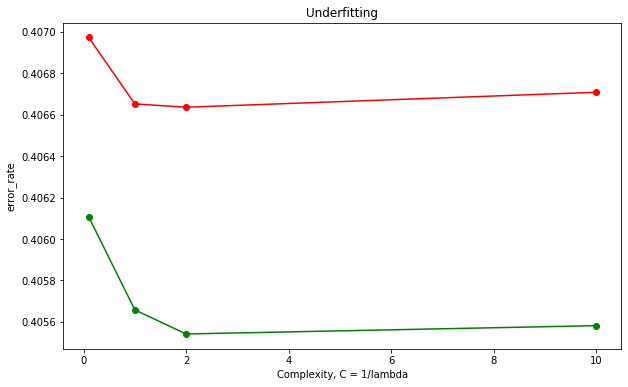

In [108]:
plt.figure(figsize=(10,6))
plt.title("Underfitting")
     
plt.xlabel("Complexity, C = 1/lambda")
plt.ylabel("error_rate")
plt.plot(complexity, GSCVError, 'o-', color="r", label="Mean Cross Validation Error Rate from GridSearchCV")
plt.plot(complexity, GSTrError, 'o-', color="g", label="Mean Cross Validation Error Rate from GridSearchCV")
plt.show()

In [0]:
y_predict_lg = lg.predict(X_test)

In [110]:
cm_lg = confusion_matrix(y_test, y_predict_lg)

print("Precision = {}".format(round(precision_score(y_test, y_predict_lg, average='macro'),3)))
print("Recall = {}".format(round (recall_score(y_test, y_predict_lg, average='macro'),3)))
print("Accuracy = {}".format(round (accuracy_score(y_test, y_predict_lg),3)))
print ("Confusion Matrix is:")
print (cm_lg)

Precision = 0.593
Recall = 0.59
Accuracy = 0.59
Confusion Matrix is:
[[13662 13207]
 [ 8723 17859]]


### XGBoost Classifier

### Ref: https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7

In [0]:
import xgboost as xgb

In [0]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

C:\Users\Shahram\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Shahram\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
#param = {
#    'eta': 0.3, 
#    'max_depth': 10,  
#    'objective': 'multi:softprob',  
#  'num_class': 5}

param = {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.6, 'num_class': 5 , 'objective': 'multi:softprob'}

steps = 20  # The number of training iterations

In [0]:
XGB = xgb.train(param, D_train, steps)

In [0]:
y_predict_XGB = XGB.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in y_predict_XGB])  # I need to investigate more about this line
cm_XGB = confusion_matrix(y_test, best_preds)

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))
print ("Confusion Matrix is:")
print (cm_XGB)

Precision = 0.6117194390528695
Recall = 0.6086825499970452
Accuracy = 0.6085573703017717
Confusion Matrix is:
[[14081 12685]
 [ 8238 18447]]


### Grid Search and HyperParameter tunning

Ref: https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

In [0]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 5, 10]
        #'num_class': [1, 5, 10]
        }

In [0]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

In [0]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 28.6min finished



 Time taken: 0 hours 37 minutes and 28.98 seconds.


In [0]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([504.04514941, 683.0878787 , 258.70228211, 235.94538252,
       445.20651007]), 'std_fit_time': array([ 1.81902976, 17.04540923,  3.41968188,  5.73382034, 12.24015832]), 'mean_score_time': array([ 3.35610835, 13.22824812,  1.65867805,  1.1766127 ,  1.96355216]), 'std_score_time': array([0.3669827 , 1.28735546, 0.38372013, 0.18317475, 0.15424216]), 'param_subsample': masked_array(data=[0.8, 0.6, 1.0, 0.8, 0.6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 5, 10, 1, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 10, 2, 2, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1, 0.5, 5, 0.5],
             mask=[False, False, False, False, False],
      

In [0]:
param = random_search.best_params_

In [0]:
param

{'subsample': 0.6,
 'min_child_weight': 5,
 'max_depth': 10,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [0]:
xgb.set_params = param
XGB = xgb.fit(X_train, y_train)

In [0]:
y_predict_xgb = xgb.predict(X_test)
cm_XGB = confusion_matrix(y_test, y_predict_xgb)

print("Precision = {}".format(precision_score(y_test, y_predict_xgb, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_predict_xgb, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_predict_xgb)))
print ("Confusion Matrix is:")
print (cm_XGB)

Precision = 0.6106796420857992
Recall = 0.6073054726119909
Accuracy = 0.6071729247348039
Confusion Matrix is:
[[13914 12852]
 [ 8145 18540]]


# Decision Tree

In [0]:
from sklearn import tree
DTC = tree.DecisionTreeClassifier()

In [0]:
#DTC = DTC.fit(X_train, y_train)
DTC.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_predict_DT = DTC.predict(X_test)

In [0]:
cm_DT = confusion_matrix(y_test, y_predict_DT)

print("Precision = {}".format (round (precision_score(y_test, y_predict_DT, average='macro'),3)))
print("Recall = {}".format    (round (recall_score(y_test, y_predict_DT, average='macro'),3)))
print("Accuracy = {}".format  (round (accuracy_score(y_test, y_predict_DT),3)))
print ("Confusion Matrix is:")
print (cm_DT)

Precision = 0.539
Recall = 0.539
Accuracy = 0.539
Confusion Matrix is:
[[14305 12461]
 [12187 14498]]


In [0]:
from sklearn.utils import shuffle
predictions_lg = lg.predict(X_test)
print(accuracy_score(y_test, predictions_lg))
#Explain why the accuracy printed here is not the same as that in the plot below or in the output from the GridSearchCV function
#Which value of the accuracy is expected for the estimates of outcomes from data the estimator has not seen before?
X_shuf, y_shuf = shuffle(X, y)

plot_learning_curve(lg, 'Logistic Regression', X_shuf, y_shuf, cv=4)

#Explain why the accuracy of the learning curve decreases with the number of training examples for the training score, 
#but increases with the number of examples for the cross-validation score
#consider over-fitting in your answer
#What is the difference between the accuracy quoted in the learning curve and the accuracy you plotted as a function of C?
#Given the outcomes for the cross validation accuracy and training accuracy as a function of the parameter values, C, do you think 
#that regularization is helpful here? Refer to the lecture notes on regularization and the sklearn documentation on logistic regression

### Extra References/Links

In [0]:
# Ref: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76384#449402

base_url = 'https://www.microsoft.com/en-us/wdsi/definitions/antimalware-definition-release-notes?RequestVersion='
#read the data the delete it then..
#do the same for test set as well..

df = pd.read_csv('train.csv', usecols=['AvSigVersion'])
search_ver = np.asarray(list(set(df['AvSigVersion'].values)))
del df

print(len(search_ver))

saved, cnt = {}, 0

for i in search_ver:
    if cnt%200 == 0:
        print('Done till', cnt, 'out of', len(search_ver))

    page = requests.get(base_url+i)
    soup = BeautifulSoup(page.text, 'html.parser')
    try:
        saved[i] = soup.find(id='availabledate').contents[0][28:]
    except Exception:
        print('Didn\'t Find For', i)
    cnt+= 1
np.save('train_AvSigVersion.npy', saved)


In [0]:
# IMPORT TIMESTAMP DICTIONARY
datedict = np.load('C:/Users/Shahram/Desktop/Microsoft Spam/AvSigVersionTimestamps.npy', allow_pickle=True)
datedict = datedict[()]
# ADD TIMESTAMPS
train['Date'] = train['AvSigVersion'].map(datedict)
#df_test['Date'] = df_test['AvSigVersion'].map(datedict)

#### Light GBM
#### Ref: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [0]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 50
params['max_depth'] = 100
clf = lgb.train(params, d_train, 100)

In [0]:
#Prediction
y_pred=clf.predict(X_test)
#convert into binary values
for i in range(0,99):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [0]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)

### Random forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)
clf.fit(X, y)  
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
print(clf.feature_importances_)
[0.14205973 0.76664038 0.0282433  0.06305659]
print(clf.predict([[0, 0, 0, 0]]))
